In [2]:
import numpy as np
import pickle as pkl
from PIL import Image as img
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [84]:
tmp = img.open('Data/Ims/1/0.jpg')
tmp = pack(np.array(tmp))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
totensor = transforms.ToTensor()
# tmp = totensor(tmp)
tmp.shape

(3, 84, 84)

In [104]:
tmp2 = torch.tensor(tmp, dtype=torch.uint8)
# normalize(tmp2)
normalize(totensor(np.transpose(tmp2.numpy(), axes=(1, 2, 0))))
# tmp.shape

tensor([[[-0.7479, -0.7308, -0.6965,  ..., -0.7308, -0.7993, -0.8678],
         [-0.6965, -0.6794, -0.6452,  ..., -1.0219, -1.0390, -1.0390],
         [-0.5596, -0.5596, -0.5596,  ..., -1.3473, -1.3130, -1.2788],
         ...,
         [ 0.3309,  0.4508,  0.4508,  ..., -1.2445, -1.6555, -1.0562],
         [ 0.2282,  0.3138,  0.3138,  ..., -1.0390, -1.1589,  0.0056],
         [ 0.1254,  0.1939,  0.1597,  ..., -1.3302, -1.4500, -0.0116]],

        [[-0.4076, -0.3901, -0.3550,  ..., -0.4076, -0.4776, -0.5476],
         [-0.3901, -0.3725, -0.3375,  ..., -0.7052, -0.7227, -0.7227],
         [-0.3375, -0.3375, -0.3375,  ..., -1.0378, -1.0028, -0.9678],
         ...,
         [ 0.3277,  0.4503,  0.4503,  ..., -1.3529, -1.7731, -1.1604],
         [ 0.2227,  0.3102,  0.3102,  ..., -1.1253, -1.2479, -0.0574],
         [ 0.1176,  0.1877,  0.1527,  ..., -1.4055, -1.5280, -0.0574]],

        [[-0.7064, -0.6890, -0.6541,  ..., -0.4275, -0.4973, -0.5670],
         [-0.7587, -0.7064, -0.6715,  ..., -0

In [27]:
def pack(np_image):
    return np.transpose(np_image, axes=(2, 0, 1))

(3, 84, 84)

In [100]:
for i in range(5):
    ims = np.zeros((600, 3, 84, 84), dtype=np.uint8)
    for j in range(600):
        im = np.array(img.open('Data/Ims/' + str(i + 1) + '/' + str(j) + '.jpg'))
        ims[j] = pack(im)

    # np.save('Data/PickledIms/' + str(95 + i), ims)
    with open('Data/PickledIms/' + str(i), 'wb') as f:
        pkl.dump(ims, f)
    print('Class {} processed.'.format(i))

Class 0 processed.
Class 1 processed.
Class 2 processed.
Class 3 processed.
Class 4 processed.


In [102]:
with open('Data/PickledIms/' + str(0), 'rb') as f:
    data = pkl.load(f)
data.shape

(600, 3, 84, 84)

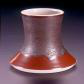

In [52]:
data = np.load('Data/PickledIms/98.npy')
tmp = img.fromarray(np.transpose(data[0], axes=(1, 2, 0)).astype(np.uint8))
tmp

In [5]:
class AugGenerator():
    def __init__(self, num_samples):
        self.num_samples = num_samples
        self.idx = np.random.permutation(num_samples) % 6
        self.rotate = transforms.RandomRotation(30)
        self.flip = transforms.RandomHorizontalFlip(1)
        self.noise = transforms.GaussianBlur(3)
        self.perspective = transforms.RandomPerspective(p=1)
        self.affine = transforms.RandomAffine(20, (0.2, 0.2))
        self.jitter = transforms.ColorJitter((0.8, 1), (0.8, 1), (0.8, 1))
        self.resize = transforms.Resize((224, 224))
        
    def reshuffle(self):
        self.idx = np.random.permutation(self.num_samples) % 6
        
    def aug(self, image, i):
        im_torch = self.resize(torch.tensor(image))
        if self.idx[i] == 0:
            return self.rotate(im_torch)
        elif self.idx[i] == 1:
            return self.flip(im_torch)
        elif self.idx[i] == 2:
            return self.noise(im_torch)
        elif self.idx[i] == 3:
            return self.perspective(im_torch)
        elif self.idx[i] == 4:
            return self.affine(im_torch)
        elif self.idx[i] == 5:
            return self.jitter(im_torch)

In [6]:
def create_episode(num_shots):
    episode = np.zeros((1, 5, num_shots, 3, 32, 32), dtype=np.uint8)

    for i in range(5):
        with open('Data/PickledIms/' + str(95 + i), 'rb') as f:
            data = pkl.load(f)

        shot_numbers = np.random.randint(0, 600, size=num_shots)
        episode[0][i][:num_shots] = data[shot_numbers]
        
    return episode

episode = create_episode(5)
episode.shape

(1, 5, 5, 3, 32, 32)

In [ ]:
num_samples = 1024
num_shots = 5
batch_size = 16
G3 = AugGenerator(num_samples)

X_aug_im = torch.zeros((5, num_samples, 3, 224, 224), device=device, dtype=torch.float32)
X_aug = torch.zeros((5, num_samples, 2048), device=device, dtype=torch.float32)
for class_num in range(5):
    for i in range(num_samples):
        X_aug_im[class_num][i] = G3.aug(episode[0][class_num][i % num_shots], i)
    for j in range(num_samples // batch_size):
        X_aug[class_num, j * batch_size:(j + 1) * batch_size] = vgg_extractor(X_aug_im[class_num,
                                                                                       j * batch_size:(j + 1) * batch_size])
    print('Class {} processed.'.format(class_num))

In [7]:
num_samples = 1024
num_shots = 5
batch_size = 16
G3 = AugGenerator(num_samples)

X_aug_im = torch.zeros((5, num_samples, 3, 224, 224), device=device, dtype=torch.float32)
X_aug = torch.zeros((5, num_samples, 2048), device=device, dtype=torch.float32)

In [20]:
X_aug_im[0][4] = G3.aug(episode[0][0][0], 4)
X_aug_im[0]

tensor([[[[161., 161., 161.,  ..., 181., 181., 181.],
          [161., 161., 161.,  ..., 181., 181., 181.],
          [161., 161., 161.,  ..., 181., 181., 181.],
          ...,
          [ 78.,  78.,  78.,  ...,  98.,  98.,  98.],
          [ 78.,  78.,  78.,  ...,  98.,  98.,  98.],
          [ 78.,  78.,  78.,  ...,  98.,  98.,  98.]],

         [[167., 167., 167.,  ..., 187., 187., 187.],
          [167., 167., 167.,  ..., 187., 187., 187.],
          [167., 167., 167.,  ..., 187., 187., 187.],
          ...,
          [ 77.,  77.,  77.,  ..., 100., 100., 100.],
          [ 77.,  77.,  77.,  ..., 100., 100., 100.],
          [ 77.,  77.,  77.,  ..., 100., 100., 100.]],

         [[217., 217., 217.,  ..., 235., 235., 235.],
          [217., 217., 217.,  ..., 235., 235., 235.],
          [217., 217., 217.,  ..., 235., 235., 235.],
          ...,
          [ 92.,  92.,  92.,  ..., 117., 117., 117.],
          [ 92.,  92.,  92.,  ..., 117., 117., 117.],
          [ 92.,  92.,  92.,  ...

In [ ]:
X_aug = vgg_extractor(X_aug_im[0, :100].reshape(-1, 3, 224, 224))
X_aug

In [36]:
X_aug.shape

torch.Size([10, 2048])